## Feature Engineer

![](../img/feature_engineer.png)

This section covers some libraries for feature engineering. 

### Split Data in a Stratified Fashion in scikit-learn

Normally, after using scikit-learn's `train_test_split`, the proportion of values in the sample will be different from the proportion of values in the entire dataset. 

In [30]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np

X, y = load_iris(return_X_y=True)
np.bincount(y)

array([50, 50, 50])

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [41]:
# Get count of each class in the train set

np.bincount(y_train)

array([37, 34, 41])

In [42]:
# Get count of each class in the test set

np.bincount(y_test)

array([13, 16,  9])

If you want to keep the proportion of classes in the sample the same as the proportion of classes in the entire dataset, add `stratify=y`. 

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [38]:
np.bincount(y_train)

array([37, 37, 38])

In [39]:
np.bincount(y_test)

array([13, 13, 12])

### Avoiding Data Leakage in Time Series Data

In time-sensitive datasets, a random split can cause data leakage by including future data in the training set, which biases the model. To prevent this, split data chronologically:

In [8]:
import pandas as pd
from datetime import datetime 
from sklearn.model_selection import train_test_split


# Sample data
data = {'customer_id': [1, 2, 3, 4, 5],
        'amount': [10.00, 20.00, 15.00, 25.00, 30.00],
        'date': ['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05']}
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

# Random split
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)
print("Random split:\n")
print("Train data:\n", train_data)  # May contain future dates
print("Test data:\n", test_data)

# Time-based split
cutoff_date = datetime(2021, 1, 4)
train_data = df[df['date'] < cutoff_date]
test_data = df[df['date'] >= cutoff_date]
print("\n\nTime-based split:\n")
print("Train data:\n", train_data)  # Data before the cutoff
print("Test data:\n", test_data)   # Data after the cutoff


Random split:

Train data:
    customer_id  amount       date
2            3    15.0 2021-01-03
0            1    10.0 2021-01-01
3            4    25.0 2021-01-04
Test data:
    customer_id  amount       date
1            2    20.0 2021-01-02
4            5    30.0 2021-01-05


Time-based split:

Train data:
    customer_id  amount       date
0            1    10.0 2021-01-01
1            2    20.0 2021-01-02
2            3    15.0 2021-01-03
Test data:
    customer_id  amount       date
3            4    25.0 2021-01-04
4            5    30.0 2021-01-05


### TimeSeriesSplit for Cross-Validation in Time Series


For time series data, using `TimeSeriesSplit` ensures the temporal order is maintained during cross-validation:

In [9]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])

tscv = TimeSeriesSplit(n_splits=3)

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}: Train={train_index}, Test={test_index}")

Fold 0: Train=[0 1 2], Test=[3]
Fold 1: Train=[0 1 2 3], Test=[4]
Fold 2: Train=[0 1 2 3 4], Test=[5]


This approach ensures:

1.  **Temporal Integrity**: Respects the data order.
2.  **Growing Training Set**: The training set increases with each fold.
3.  **Forward-Moving Test Set**: The test set is always a future sample.
4.  **No Data Leakage**: Future information is never used to predict past events.

### Enhancing Data Handling with scikit-learn's DataFrame Support

By default, scikit-learn transformers return NumPy arrays. To return pandas DataFrames, use the `set_output` method:

In [10]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

data = {"age": [25, 30, None, 35], "income": [50000, 60000, 70000, None]}
df = pd.DataFrame(data)

scaler = StandardScaler().set_output(transform='pandas')
print(scaler.fit_transform(df))


        age    income
0 -1.224745 -1.224745
1  0.000000  0.000000
2       NaN  1.224745
3  1.224745       NaN


You can apply this in pipelines too:

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("imputer", SimpleImputer(strategy="mean")), 
                     ("scaler", StandardScaler())]).set_output(transform="pandas")

print(pipeline.fit_transform(df))


        age    income
0 -1.414214 -1.414214
1  0.000000  0.000000
2  0.000000  1.414214
3  1.414214  0.000000


### Efficient Feature Transformation with make_column_transformer in scikit-learn

`make_column_transformer` allows you to apply different transformations to specific feature sets:

In [17]:
import pandas as pd
import numpy as np

data = {
    "cat1": ["A", "B", "A", np.nan, "C"],
    "cat2": ["X", "Y", np.nan, "X", "Z"],
    "num1": [10, np.nan, 15, 25, 30],
    "num2": [1.5, 2.0, np.nan, 2.2, 1.9],
}

X = pd.DataFrame(data)
y = pd.Series([0, 1, 0, 0, 1])


In [18]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression


# Define the numeric and categorical features
numeric_features = ["num1", "num2"]
categorical_features = ["cat1", "cat2"]

# Define the transformers and their corresponding columns
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder(sparse_output=False)
)
# Create the ColumnTransformer
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Fit and transform the data
X_transformed = preprocessor.fit_transform(X)
X_transformed


,num1,num2,cat1_A,cat1_B,cat1_C,cat2_X,cat2_Y,cat2_Z
0,-1.414214,-1.791093,1.0,0.0,0.0,1.0,0.0,0.0
1,0.000000,0.393167,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.707107,0.174741,1.0,0.0,0.0,1.0,0.0,0.0
3,0.707107,1.266871,1.0,0.0,0.0,1.0,0.0,0.0
4,1.414214,-0.043685,0.0,0.0,1.0,0.0,0.0,1.0


You can integrate this into a pipeline with a machine learning model:


In [19]:
pipe = make_pipeline(preprocessor, LogisticRegression())
pipe.fit(X, y)
pipe.predict(X)


array([0, 1, 0, 0, 1])

This streamlines feature preprocessing and modeling in one unified workflow.

### FunctionTransformer: Build Robust Preprocessing Pipelines with Custom Transformations

If you need to apply custom transformations within a scikit-learn pipeline, the `FunctionTransformer` is a useful tool to wrap any function for preprocessing.

In [3]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log1p)
X = np.array([[0, 1], [2, 3]])
transformer.transform(X)

array([[0.        , 0.69314718],
       [1.09861229, 1.38629436]])

This allows you to seamlessly integrate custom functions into a pipeline, maintaining consistency across transformations for different datasets.

Here's an example of using `FunctionTransformer` in a full pipeline:

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Create a simple pandas DataFrame
data = {
    "feature1": [1, 2, 3, 4, 5],
    "feature2": [6, 7, 8, 9, 10],
    "target": [0, 0, 1, 1, 1],
}
df = pd.DataFrame(data)

# Split the DataFrame into features and target
X = df[["feature1", "feature2"]]
y = df["target"]

# Define the FunctionTransformer
log_transformer = FunctionTransformer(np.log1p)


# Define the pipeline
pipeline = Pipeline(
    [("log_transform", log_transformer), ("classifier", LogisticRegression())]
)

# Fit the pipeline on the data
pipeline.fit(X, y)

# Make predictions on new data
new_data = {"feature1": [6, 7], "feature2": [11, 12]}
new_df = pd.DataFrame(new_data)
predictions = pipeline.predict(new_df)

# Print the predictions
print("Predictions:", predictions)

Predictions: [1 1]


### Drop Correlated Features

In [ ]:
!pip install feature_engine 

To remove highly correlated features, you can use `DropCorrelatedFeatures` from the `feature-engine` package.

In [21]:
import pandas as pd
from sklearn.datasets import make_classification
from feature_engine.selection import DropCorrelatedFeatures

# Create a dataset with correlated variables
X, y = make_classification(
    n_samples=1000, n_features=6, n_redundant=3, n_clusters_per_class=1, class_sep=2, random_state=0
)

# Convert the dataset to a DataFrame
colnames = ["var_" + str(i) for i in range(6)]
X = pd.DataFrame(X, columns=colnames)

# Drop features with correlation above 0.8
tr = DropCorrelatedFeatures(threshold=0.8)
Xt = tr.fit_transform(X)

# Check correlated features
print("Correlated features:", tr.correlated_feature_sets_)
print("Remaining features:", Xt.columns)


Correlated features: [{'var_0', 'var_2', 'var_1'}]
Remaining features: Index(['var_0', 'var_3', 'var_4', 'var_5'], dtype='object')


[Link to feature-engine](https://feature-engine.trainindata.com).

### Encode Rare Labels with Feature-engine

Handling rare categories in high-cardinality categorical features can be simplified using the `RareLabelEncoder`. This encoder groups infrequent categories into a single value.

In [15]:
from sklearn.datasets import fetch_openml
from feature_engine.encoding import RareLabelEncoder

data = fetch_openml('dating_profile')['data']
data.head(10)

,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...","books:<br />\nabsurdistan, the republic, of mi...",...,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,None,i am die hard christopher moore fan. i don't r...,...,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,thin,anything,socially,None,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,...,"san francisco, california",None,straight,has cats,None,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,thin,vegetarian,socially,None,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . .<br />\nlynch, j...",...,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,None,m,pisces,no,"english, german (poorly)",single
4,athletic,None,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians<br />\nat the...",...,"san francisco, california",None,straight,likes dogs and likes cats,None,m,aquarius,no,english,single
5,average,mostly anything,socially,None,graduated from college/university,"i'm an australian living in san francisco, but...",building awesome stuff. figuring out what's im...,imagining random shit. laughing at aforementio...,i have a big smile. i also get asked if i'm we...,"books: to kill a mockingbird, lord of the ring...",...,"san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes cats,atheism,m,taurus,no,"english (fluently), chinese (okay)",single
6,fit,strictly anything,socially,never,graduated from college/university,life is about the little things. i love to lau...,digging up buried treasure,frolicking<br />\nwitty banter<br />\nusing my...,i am the last unicorn,i like books. ones with pictures. reading them...,...,"san francisco, california",None,straight,likes dogs and likes cats,None,f,virgo,None,english,single
7,average,mostly anything,socially,never,graduated from college/university,None,"writing. meeting new people, spending time wit...","remembering people's birthdays, sending cards,...",i'm rather approachable (a byproduct of being ...,"i like: alphabetized lists, aquariums, autobio...",...,"san francisco, california","doesn&rsquo;t have kids, but wants them",straight,likes dogs and likes cats,christianity,f,sagittarius,no,"english, spanish (okay)",single
8,None,strictly anything,socially,None,graduated from college/university,None,"oh goodness. at the moment i have 4 jobs, so i...",None,i'm freakishly blonde and have the same name a...,i am always willing to try new foods and am no...,...,"belvedere tiburon, californ

In [20]:
# Drop rows with missing values in 'education' column

processed = data.dropna(subset=['education'])

In the code below, 
- `tol` species the minimum frequency below which a category is considered rare. 
- `replace_with` species the value to be used to replace rare categories.
- `variables` specify the list of categorical variables that will be encoded.

In [23]:
encoder = RareLabelEncoder(tol=0.05, variables=["education"], replace_with="Other")
encoded = encoder.fit_transform(processed)

Now the rare categories in the column `education` are replaced with "Other".

In [25]:
encoded['education'].sample(10)

46107                                Other
45677       graduated from masters program
57928    graduated from college/university
53127        working on college/university
33300                                Other
33648       graduated from masters program
59701                                Other
57013       graduated from masters program
46428    graduated from college/university
57123    graduated from college/university
Name: education, dtype: object

[Link to feature-engine](https://feature-engine.trainindata.com).

### Encode Categorical Data Using Frequency

In [ ]:
!pip install feature-engine

Sometimes, encoding categorical variables based on frequency or count can improve model performance. `CountFrequencyEncoder` from `feature-engine` helps achieve this.

In [35]:
import seaborn as sns
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.model_selection import train_test_split

data = sns.load_dataset("diamonds")

X_train, X_test, y_train, y_test = train_test_split(data, data["price"], random_state=0)
X_train

,carat,cut,color,clarity,depth,table,price,x,y,z
441,0.89,Premium,H,SI2,60.2,59.0,2815,6.26,6.23,3.76
50332,0.70,Very Good,D,SI1,64.0,53.0,2242,5.57,5.61,3.58
35652,0.31,Ideal,G,VVS2,62.7,57.0,907,4.33,4.31,2.71
9439,0.90,Very Good,H,VS1,62.3,59.0,4592,6.12,6.17,3.83
15824,1.01,Good,F,VS2,60.6,62.0,6332,6.52,6.49,3.94
...,...,...,...,...,...,...,...,...,...,...
45891,0.52,Premium,F,VS2,60.7,59.0,1720,5.18,5.14,3.13
52416,0.70,Good,D,SI1,63.6,60.0,2512,5.59,5.51,3.51
42613,0.32,Premium,I,VS1,61.3,58.0,505,4.35,4.39,2.68
43567,0.41,Ideal,G,IF,61.0,57.0,1431,4.81,4.79,2.93


<IPython.core.display.Javascript object>

Encode `color` and `clarity`: 

In [36]:
# initiate an encoder
encoder = CountFrequencyEncoder(
    encoding_method="frequency", variables=["color", "clarity"]
)

# fit the encoder
encoder.fit(X_train)

# process the data
p_train = encoder.transform(X_train)
p_test = encoder.transform(X_test)

<IPython.core.display.Javascript object>

In [37]:
p_test

,carat,cut,color,clarity,depth,table,price,x,y,z
10176,1.10,Ideal,0.152762,0.170436,62.0,55.0,4733,6.61,6.65,4.11
16083,1.29,Ideal,0.152762,0.242022,62.6,56.0,6424,6.96,6.93,4.35
13420,1.20,Premium,0.100531,0.242022,61.1,58.0,5510,6.88,6.80,4.18
20407,1.50,Ideal,0.179409,0.242022,60.9,56.0,8770,7.43,7.36,4.50
8909,0.90,Very Good,0.179409,0.227314,61.7,57.0,4493,6.17,6.21,3.82
...,...,...,...,...,...,...,...,...,...,...
52283,0.59,Very Good,0.182005,0.094401,61.7,59.0,2494,5.37,5.36,3.31
10789,1.00,Fair,0.152762,0.227314,64.8,62.0,4861,6.22,6.13,4.00
1190,0.70,Very Good,0.179409,0.094401,63.2,58.0,2932,5.66,5.60,3.56
3583,0.59,Ideal,0.182005,0.067384,60.7,57.0,3422,5.41,5.45,3.29


<IPython.core.display.Javascript object>

[Link to feature-engine](https://feature-engine.trainindata.com).

### Similarity Encoding for Dirty Categories Using dirty_cat

In [ ]:
!pip install dirty-cat

To handle dirty categorical variables, use dirty\_cat's `SimilarityEncoder`. This captures similarities between categories that may contain typos or variations.

Example using the employee_salaries dataset:

In [9]:
from dirty_cat.datasets import fetch_employee_salaries
from dirty_cat import SimilarityEncoder

X = fetch_employee_salaries().X
X.head(10)

,gender,department,department_name,division,assignment_category,employee_position_title,underfilled_job_title,date_first_hired,year_first_hired
0,F,POL,Department of Police,MSB Information Mgmt and Tech Division Records...,Fulltime-Regular,Office Services Coordinator,NaN,09/22/1986,1986
1,M,POL,Department of Police,ISB Major Crimes Division Fugitive Section,Fulltime-Regular,Master Police Officer,NaN,09/12/1988,1988
2,F,HHS,Department of Health and Human Services,Adult Protective and Case Management Services,Fulltime-Regular,Social Worker IV,NaN,11/19/1989,1989
3,M,COR,Correction and Rehabilitation,PRRS Facility and Security,Fulltime-Regular,Resident Supervisor II,NaN,05/05/2014,2014
4,M,HCA,Department of Housing and Community Affairs,Affordable Housing Programs,Fulltime-Regular,Planning Specialist III,NaN,03/05/2007,2007
5,M,POL,Department of Police,PSB 6th District Special Assignment Team,Fulltime-Regular,Police Officer III,NaN,07/16/2007,2007
6,F,FRS,Fire and Rescue Services,EMS Billing,Fulltime-Regular,Accountant/Auditor II,NaN,06/27/2016,2016
7,M,HHS,Department of Health and Human Services,Head Start,Fulltime-Regular,Administrative Specialist II,NaN,11/17/2014,2014
8,M,FRS,Fire and Rescue Services,Recruit Training,Fulltime-Regular,Firefighter/Rescuer III,Firefighter/Rescuer I (Recruit),12/12/2016,2016
9,F,POL,Department of Police,FSB Traffic Division Automated Traffic Enforce...,Fulltime-Regular,Police Aide,NaN,02/05/2007,2007


In [21]:
dirty_column = "employee_position_title"
X_dirty = df[dirty_column].values
X_dirty[:7]

array(['Office Services Coordinator', 'Master Police Officer',
       'Social Worker IV', 'Resident Supervisor II',
       'Planning Specialist III', 'Police Officer III',
       'Accountant/Auditor II'], dtype=object)

We can see that titles such as 'Master Police Officer' and 'Police Officer III' are similar. We can use `SimilaryEncoder` to get an array that encodes the similarity between different job titles.

In [19]:
enc = SimilarityEncoder(similarity="ngram")
X_enc = enc.fit_transform(X_dirty[:10].reshape(-1, 1))
X_enc

array([[0.05882353, 0.03125   , 0.02739726, 0.19008264, 1.        ,
        0.01351351, 0.05555556, 0.20535714, 0.08088235, 0.032     ],
       [0.008     , 0.02083333, 0.056     , 1.        , 0.19008264,
        0.02325581, 0.23076923, 0.56      , 0.01574803, 0.02777778],
       [0.03738318, 0.07317073, 0.05405405, 0.02777778, 0.032     ,
        0.0733945 , 0.        , 0.0625    , 0.06542056, 1.        ],
       [0.11206897, 0.07142857, 0.09756098, 0.01574803, 0.08088235,
        0.07142857, 0.03125   , 0.08108108, 1.        , 0.06542056],
       [0.04761905, 0.3539823 , 0.06976744, 0.02325581, 0.01351351,
        1.        , 0.02      , 0.09821429, 0.07142857, 0.0733945 ],
       [0.0733945 , 0.05343511, 0.14953271, 0.56      , 0.20535714,
        0.09821429, 0.26086957, 1.        , 0.08108108, 0.0625    ],
       [1.        , 0.05      , 0.06451613, 0.008     , 0.05882353,
        0.04761905, 0.01052632, 0.0733945 , 0.11206897, 0.03738318],
       [0.05      , 1.        , 0.0337837

To better visualize the similarity, create a heatmap:

In [23]:
import seaborn as sns
import numpy as np
from sklearn.preprocessing import normalize
from IPython.core.pylabtools import figsize

def plot_similarity(labels, features):
  
    normalized_features = normalize(features)
    
    # Create correction matrix
    corr = np.inner(normalized_features, normalized_features)
    
    # Plot
    figsize(10, 10)
    sns.set(font_scale=1.2)
    g = sns.heatmap(corr, xticklabels=labels, yticklabels=labels, vmin=0,
        vmax=1, cmap="YlOrRd", annot=True, annot_kws={"size": 10})
        
    g.set_xticklabels(labels, rotation=90)
    g.set_title("Similarity")


def encode_and_plot(labels):
  
    enc = SimilarityEncoder(similarity="ngram") # Encode
    X_enc = enc.fit_transform(labels.reshape(-1, 1))
    
    plot_similarity(labels, X_enc) # Plot

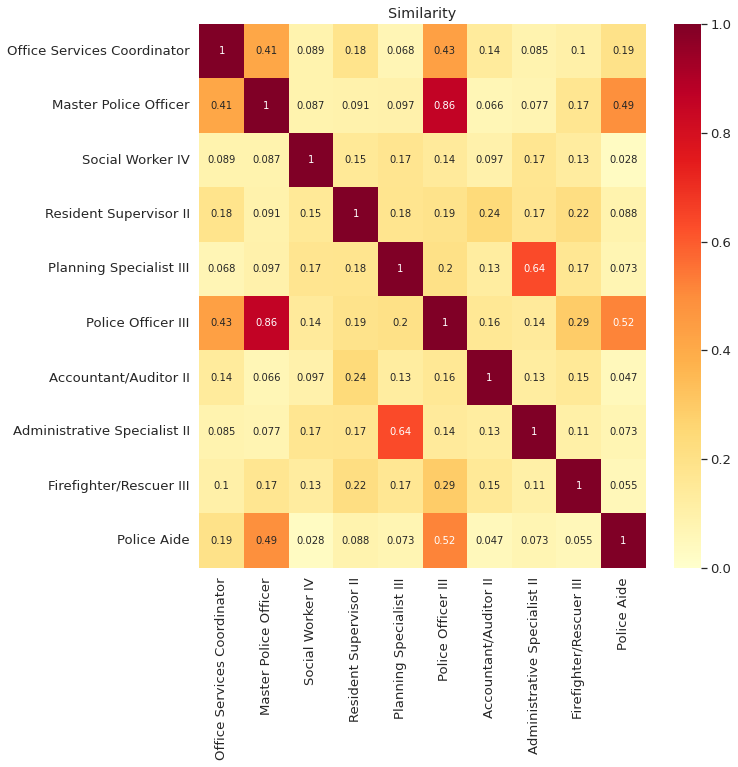

In [25]:
encode_and_plot(X_dirty[:10])

As we can see from the matrix above,
- The similarity between the same strings such as 'Office Services Coordinator' and 'Office Services Coordinator' is 1
- The similarity between somewhat similar strings such as 'Office Services Coordinator' and 'Master Police Officer' is 0.41
- The similarity between two very different strings such as 'Social Worker IV' and 'Polic Aide' is 0.028

[Link to dirty-cat](https://dirty-cat.github.io/).

### How to Handle Misspellings in Real-World Datasets

In [ ]:
!pip install git+https://github.com/skrub-data/skrub.git

Real-world datasets often contain misspellings and variations in categorical variables, especially when data is manually entered. This can cause issues with data analysis steps that require exact matching, such as GROUP BY operations.

skrub's `deduplicate()` function helps solve this problem by using unsupervised learning to cluster similar strings and automatically correct misspellings. 

To demonstrate the deduplicate function, start with generating a duplicated dataset:

In [103]:
from skrub.datasets import make_deduplication_data
import pandas as pd

duplicated_food = make_deduplication_data(
    examples=["Chocolate", "Broccoli", 'Jalapeno', 'Zucchini'],  
    entries_per_example=[100, 200, 300, 200],  # their respective number of occurrences
    prob_mistake_per_letter=0.05,  # 5% probability of typo per letter
    random_state=42,  # set seed for reproducibility
)

Get the most common food names:

In [104]:
duplicated_food

['Chocolate',
 'Cgocolate',
 'Chocolate',
 'Chqcolate',
 'Chocoltte',
 'Chocolate',
 'Chocdlate',
 'Chocolate',
 'ehocolate',
 'Chocolate',
 'Chocolatw',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Chocolate',
 'Choc

In [109]:
pd.Series(duplicated_food).value_counts()[:4]

Jalapeno     284
Zucchini     195
Broccoli     193
Chocolate     94
Name: count, dtype: int64

The most common words in the dataset are 'Jalapeno', 'Zucchini', and 'Broccoli'. Therefore, skub's deduplicate function replaces misspelled words with the closest matching word from this set.

In [106]:
from skrub import deduplicate

# create a table that maps original to corrected categories
translation_table = deduplicate(duplicated_food)

# remove duplicated rows
translation_table = translation_table.reset_index().rename(columns={'index': 'mispelled_food', 0: 'corrected_food'}).drop_duplicates()

# view 10 sample rows
print(translation_table.sample(10, random_state=2))

    mispelled_food corrected_food
122       sroccoli       Broccoli
123       Brzccoli       Broccoli
336       oalapeno       Jalapeno
600       Zucchtni       Zucchini
301       Jalapeno       Jalapeno
105       Brojcoli       Broccoli
602       Zycchini       Zucchini
0        Chocolate      Chocolate
617       Zucchzni       Zucchini
319       Jalapend       Jalapeno


[Link to skub](https://github.com/skrub-data/skrub/).

### Solving Data Mismatches: Joining Tables with Fuzzy Matching

In [ ]:
!pip install git+https://github.com/skrub-data/skrub.git

In [10]:
# We will ignore the warnings:
import warnings

warnings.filterwarnings("ignore")

When joining two tables with non-exact matching entries, such as "Yemen\*" in one table and "Yemen, Rep." in another, use skrub's `fuzzy_join()`:

In [13]:
import pandas as pd

df = pd.read_csv(
    "https://raw.githubusercontent.com/skrub-data/datasets/master/data/Happiness_report_2022.csv",
    thousands=",",
)
df = df[["Country", "Happiness score"]]

In [14]:
from skrub.datasets import fetch_world_bank_indicator
gdppc = fetch_world_bank_indicator(indicator_id="NY.GDP.PCAP.CD").X

In [30]:
print(df.sort_values(by="Country").tail(6))

       Country  Happiness score
107  Venezuela           4925.0
76     Vietnam           5485.0
131     Yemen*           4197.0
136     Zambia           3760.0
143   Zimbabwe           2995.0
146         xx              NaN


In [19]:
print(gdppc.sort_values(by="Country Name").tail(5))

           Country Name  GDP per capita (current US$)
193  West Bank and Gaza                   3789.327966
255               World                  12647.480789
258         Yemen, Rep.                    701.714878
260              Zambia                   1487.907764
261            Zimbabwe                   1266.996031


In [33]:
from skrub import fuzzy_join

df1 = fuzzy_join(
    df,  # our table to join
    gdppc,  # the table to join with
    left_on="Country",  # the first join key column
    right_on="Country Name",  # the second join key column
    return_score=True,
)

print(df1[['Country', 'Country Name', "matching_score"]].tail(20))
# We merged the first WB table to our initial one.

          Country                                 Country Name  matching_score
127   Madagascar*                                   Madagascar        0.795045
128         Egypt                             Egypt, Arab Rep.        0.654033
129         Chad*                                         Chad        0.683373
130      Ethiopia                                     Ethiopia        1.000000
131        Yemen*                                  Yemen, Rep.        0.653668
132   Mauritania*                                   Mauritania        0.810736
133        Jordan                                       Jordan        1.000000
134          Togo                                         Togo        1.000000
135         India                                        India        1.000000
136        Zambia                                       Zambia        1.000000
137        Malawi                                       Malawi        1.000000
138      Tanzania                                   

[Link to skrub](https://github.com/skrub-data/skrub/).

### Snorkel — Programmatically Build Training Data in Python

In [ ]:
!pip install snorkel

Let’s say you want to detect fake job postings based on a few assumptions:

*   Few or no requirements make a job likely fake.
*   No company profile or logo is a red flag.
*   Real jobs usually require education or experience.

You can load a sample dataset like this:

In [22]:
import pandas as pd 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


train_df = pd.read_pickle(
    "https://github.com/khuyentran1401/Data-science/blob/master/feature_engineering/snorkel_example/train_fake_jobs.pkl?raw=true"
)
train_df.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
12276,12277,Big Data Analyst,"GB, WSM, London",Product Ops,NaN,Founded in 2010 by a team from Google’s London...,Qubit: Cutting Edge Big Data EngineeringQubit ...,"What you'll need: A background in consulting, ...",Plenty of perks:As well as the opportunity to ...,0,1,1,Full-time,Associate,Bachelor's Degree,Internet,Product Management,0
14680,14681,Instructional Advocate,"US, GA, Savannah",NaN,NaN,We are an after-school program committed to as...,21st Century Community Learning Centers is an ...,Bachelor's Degree or an Associate's Degree; or...,NaN,0,1,0,Part-time,NaN,NaN,NaN,Education,0
16518,16519,Software Developer,"US, FL, Gainesville",NaN,NaN,352 Inc. is a full-service digital agency crea...,We partner with great clients to build smart s...,3-5 years of great c# work Experience in mvc o...,What You’ll GetFreedom: We trust you to do you...,0,1,0,Full-time,Mid-Senior level,NaN,Computer Software,Information Technology,0
15478,15479,Internship in India,"IN, , Bangalore",NaN,NaN,,"London is a fast paced city of culture, divers...",,As specialists in delivering high quality and ...,0,1,0,NaN,NaN,NaN,NaN,NaN,0
16348,16349,Web Developer Backend Microservices (m/f),"DE, BE, 10969",Engineering,NaN,airfy prägt sicheres und einfach zu bedienende...,Design and develop a microservice platform for...,"Senior level experience with web backends, esp...",Flat hierarchies and a productive work environ...,0,1,0,Full-time,Associate,Bachelor's Degree,Internet,Engineering,0


<IPython.core.display.Javascript object>

Snorkel helps programmatically label data. Start by defining labels:

In [15]:
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis

FAKE = 1
REAL = 0
ABSTAIN = -1

<IPython.core.display.Javascript object>

You can create labeling functions to reflect your assumptions:

In [29]:
@labeling_function()
def no_company_profile(x: pd.Series):
    return FAKE if x.company_profile == "" else ABSTAIN


@labeling_function()
def no_company_logo(x: pd.Series):
    return FAKE if x.has_company_logo == 0 else ABSTAIN


@labeling_function()
def required_experience(x: pd.Series):
    return REAL if x.required_experience else ABSTAIN


@labeling_function()
def required_education(x: pd.Series):
    return REAL if x.required_education else ABSTAIN

<IPython.core.display.Javascript object>

Use these functions to label your data:

In [30]:
lfs = [
    no_company_profile,
    no_company_logo,
    required_experience,
    required_education,
]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=train_df)

100%|██████████████████████████████████████████████| 13410/13410 [00:02<00:00, 5849.25it/s]


<IPython.core.display.Javascript object>

Finally, evaluate the accuracy of your labeling functions:

In [31]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary(Y=train_df.fraudulent.values)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
no_company_profile,0,[1],0.186204,0.186204,0.186204,459,2038,0.183821
no_company_logo,1,[1],0.205742,0.205742,0.205742,459,2300,0.166365
required_experience,2,[0],1.000000,1.000000,0.244295,12741,669,0.950112
required_education,3,[0],1.000000,1.000000,0.244295,12741,669,0.950112


<IPython.core.display.Javascript object>

This analysis provides insights on coverage, accuracy, and overlaps between labeling functions.

[Link to Snorkel](https://www.snorkel.org/).

### sketch: AI Code-Writing Assistant That Understands Data Content

Wouldn't it be nice if you could get insights into your data by simply asking a question? Sketch allows you to do exactly that.

Sketch is an AI code-writing assistant for pandas users that understands the context of your data.

In [ ]:
!pip install sketch

In [3]:
import pandas as pd  
import seaborn as sns 
import sketch

In [18]:
data = sns.load_dataset('taxis')
data.head(10)

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan
5,2019-03-11 10:37:23,2019-03-11 10:47:31,1,0.49,7.5,2.16,0.0,12.96,yellow,credit card,Times Sq/Theatre District,Midtown East,Manhattan,Manhattan
6,2019-03-26 21:07:31,2019-03-26 21:17:29,1,3.65,13.0,2.00,0.0,18.80,yellow,credit card,Battery Park City,Two Bridges/Seward Park,Manhattan,Manhattan
7,2019-03-22 12:47:13,2019-03-22 12:58:17,0,1.40,8.5,0.00,0.0,11.80,yellow,NaN,Murray Hill,Flatiron,Manhattan,Manhattan
8,2019-03-23 11:48:50,2019-03-23 12:06:14,1,3.63,15.0,1.00,0.0,19.30,yellow,credit card,East Harlem South,Midtown Center,Manhattan,Manhattan
9,2019-03-08 16:18:37,2019-03-08 16:26:57,1,1.52,8.0,1.00,0.0,13.30,yellow,credit card,Lincoln Square East,Central Park,Manhattan,Manhattan


In [20]:
data.sketch.ask(
    "Can you give me friendly names for each column?" 
    "(Output as an HTML list)"
)

In [21]:
data.sketch.ask(
    "Which payment is the most popular payment?"
)

In [22]:
data.sketch.howto("Create some features from the pickup column")

In [23]:

# Create a new column for the hour of the pickup
data['pickup_hour'] = data['pickup'].dt.hour

# Create a new column for the day of the week of the pickup
data['pickup_day'] = data['pickup'].dt.weekday

# Create a new column for the month of the pickup
data['pickup_month'] = data['pickup'].dt.month_name()


In [24]:
data.sketch.howto(
    "Create some features from the pickup_zone column"
)

In [25]:

# Create a new column called 'pickup_zone_count'
data['pickup_zone_count'] = data.groupby('pickup_zone')['pickup_zone'].transform('count')

# Create a new column called 'pickup_zone_fare'
data['pickup_zone_fare'] = data.groupby('pickup_zone')['fare'].transform('mean')

# Create a new column called 'pickup_zone_distance'
data['pickup_zone_distance'] = data.groupby('pickup_zone')['distance'].transform('mean')


In [26]:
data 

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough,pickup_hour,pickup_day,pickup_month,pickup_zone_count,pickup_zone_fare,pickup_zone_distance
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan,20,5,March,120.0,9.016667,1.857083
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan,16,0,March,144.0,9.987778,2.031597
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan,17,2,March,9.0,11.944444,2.796667
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan,1,6,March,47.0,11.000000,2.243830
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan,13,5,March,198.0,10.994949,2.239798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6428,2019-03-31 09:51:53,2019-03-31 09:55:27,1,0.75,4.5,1.06,0.0,6.36,green,credit card,East Harlem North,Central Harlem North,Manhattan,Manhattan,9,6,March,72.0,12.550000,2.854306
6429,2019-03-31 17:38:00,2019-03-31 18:34:23,1,18.74,58.0,0.00,0.0,58.80,green,credit card,Jamaica,East Concourse/Concourse Village,Queens,Bronx,17,6,March,12.0,25.597500,7.261667
6430,2019-03-23 22:55:18,2019-03-23 23:14:25,1,4.14,16.0,0.00,0.0,17.30,green,cash,Crown Heights North,Bushwick North,Brooklyn,Brooklyn,22,5,March,12.0,14.549167,3.665000
6431,2019-03-04 10:09:25,2019-03-04 10:14:29,1,1.12,6.0,0.00,0.0,6.80,green,credit card,East New York,East Flatbush/Remsen Village,Brooklyn,Brooklyn,10,0,March,10.0,32.409000,7.086000


[Link to Sketch](https://github.com/approximatelabs/sketch).